# 提案手法の実験（ラベルが適切か出力）

## マルチサイズ
- データオーギュメンテーション（鏡映，回転を追加）

### import，入力データの読み込み

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# AIX環境での proxy の設定．
# keras.datasetsでは，datasetを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "https://proxy.uec.ac.jp:8080/"
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/LSWMD.pkl


In [2]:
import os
from os.path import join
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

import csv

import numpy as np
import pandas as pd
import pickle
import copy
import cv2
import random
import glob

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import joblib

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(logical_gpus)
import keras
from tensorflow.keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
import keras.backend.tensorflow_backend as tfback
# from tf.keras.utils import multi_gpu_model


import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

datapath = join('data', 'wafer')
print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU') memory growth: True
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU') memory growth: True
PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU') memory growth: True
[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU'), LogicalDevice(name='/device:GPU:2', device_type='GPU'), LogicalDevice(name='/device:GPU:3', device_type='GPU')]


Using TensorFlow backend.


['LSWMD.pkl']


In [3]:
# Define
max_size = 100
encord_size = int(max_size / 2)

NOTEBOOK_NAME = 'wafermap_multisize_train_validation_rotation_vgg'
cnn_path = './model/cnn_' + str(max_size) + '_' + NOTEBOOK_NAME + '.h5'

epoch = 30
batch_size = 2048

In [4]:
faulty_case = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']


### 学習を行う
- 不良ラベルを0-8の9次元のベクトルとして表現する．
- one-hotエンコーディングを行っている．

### データの読み出し

- train

In [5]:
# acquire the .npy name
data_size = len(glob.glob('./data/multi_' + str(max_size) + '/train_rotation/' + '*.npy'))
TRAINS = ['./data/multi_' + str(max_size) + '/train_rotation/' + str(i) + '.npy' for i in range(data_size)]
# one-hot-encoding
y = joblib.load('./data/multi_' + str(max_size) + '/train_rotation/y.pickle')
new_y = to_categorical(y)
# split test

# shuffle_indices = random.sample(list(range(len(TRAINS))), 10000)
# TRAINS = [TRAINS[i] for i in shuffle_indices]
# new_y = new_y[shuffle_indices]

x_train = TRAINS
y_train = new_y

- validaiton

In [6]:
# acquire the .npy name
data_size = len(glob.glob('./data/multi_' + str(max_size) + '/validation_rotation/' + '*.npy'))
VALIDATIONS = ['./data/multi_' + str(max_size) + '/validation_rotation/' + str(i) + '.npy' for i in range(data_size)]
# one-hot-encoding
y = joblib.load('./data/multi_' + str(max_size) + '/validation_rotation/y.pickle')
new_y = to_categorical(y)
# split test

# shuffle_indices = random.sample(list(range(len(TRAINS))), 10000)
# TRAINS = [TRAINS[i] for i in shuffle_indices]
# new_y = new_y[shuffle_indices]

x_validation = VALIDATIONS
y_validation = new_y

In [7]:
# batchを取得する関数
from multiprocessing import Pool
import time

def load_array(file):
    return np.load(file)

def get_batch(batch_size): 
    global x_train, y_train
    SIZE = len(x_train)
    # n_batchs
    n_batchs = SIZE//batch_size + 1
    # for でyield
    i = 0
    start = time.time()
    while (i < n_batchs):
        print("doing", i, "/", n_batchs)
        Y_batch = y_train[(i * batch_size):((i + 1) * batch_size)]
        
        #あるbatchのfilenameの配列を持っておく
        X_batch_name = x_train[(i * batch_size):((i + 1) * batch_size)]

        # filenameにしたがってバッチのtensorを構築
        with Pool() as p:
            arr = p.map(load_array, X_batch_name)
            
        X_batch = np.array(arr).reshape(len(X_batch_name), max_size, max_size, 3)
#         X_batch = np.array([np.load(file)
#                             for file in X_batch_name]).reshape(len(X_batch_name), max_size, max_size, 3)
        i += 1
        print('elapsed time', time.time()-start)
        yield X_batch, Y_batch

- 学習データとテストデータに分割する．

In [8]:
print('Train x : {}, y : {}'.format(len(x_train), y_train.shape))
print('Validation x: {}, y : {}'.format(len(x_validation), y_validation.shape))

Train x : 283171, y : (283171, 9)
Validation x: 4500, y : (4500, 9)


In [9]:
print("loading X_validation...")
with Pool() as p:
    arr = p.map(load_array, x_validation)

x_validation = np.array(arr).reshape(len(x_validation), max_size, max_size, 3)

loading X_validation...


- 学習データ246635枚，テストデータ121477枚．

- モデルの定義を行う．

### CNN

In [10]:
def create_model():
#     with tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], 
    with tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3"], 
                                        cross_device_ops = tf.distribute.HierarchicalCopyAllReduce()).scope():
        input_shape = (max_size, max_size, 3)
        input_tensor = Input(input_shape)

        conv_1 = layers.Conv2D(8, (3,3), activation='relu', padding='same')(input_tensor)
        conv_2 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(conv_1)
        conv_3 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv_2)

        flat = layers.Flatten()(conv_3)

        dense_1 = layers.Dense(64, activation='relu')(flat)
        dense_2 = layers.Dense(32, activation='relu')(dense_1)
        output_tensor = layers.Dense(9, activation='softmax')(dense_2)

        model = models.Model(input_tensor, output_tensor)
        model.compile(optimizer='Adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

    return model

In [11]:
def vgg_model():
#     with tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], 
    with tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3"], 
                                        cross_device_ops = tf.distribute.HierarchicalCopyAllReduce()).scope():
        
        vgg = tf.keras.applications.vgg16.VGG16(
            include_top=False, input_shape=(max_size, max_size, 3)
        )
        flat = layers.Flatten()(vgg.output)
        dense_1 = layers.Dense(64, activation='relu')(flat)
        dense_2 = layers.Dense(32, activation='relu')(dense_1)
        x = layers.Dense(9, activation='softmax')(dense_2)
        
#         vgg.trainable = False

        model = models.Model(vgg.input, x)
        model.compile(optimizer='Adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

    return model

In [12]:
model = vgg_model()
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_______

- Cross validationなしで学習する．

In [13]:
epoch=10
batch_size=1024
random.seed(1)

In [14]:
model = vgg_model()
epoch_train_loss = []
epoch_train_acc = []
epoch_validation_loss = []
epoch_validation_acc = []
for ep in range(epoch):
    print("=" * 50)
    print(ep, "/", epoch)
    step_loss = []
    step_acc = []
    
    # batch_size=1000でHDDからバッチを取得する
    for X_batch, Y_batch in get_batch(batch_size):
        model.train_on_batch(X_batch, Y_batch)
        score = model.evaluate(X_batch, Y_batch)
        print("batch loss:", score[0])
        print("batch accuracy:", score[1])
        step_loss.append(score[0])
        step_acc.append(score[1])
    print("Train loss", np.mean(step_loss))
    print("Train accuracy", np.mean(step_acc))
    score = model.evaluate(x_validation, y_validation)
    print("Validation loss:", score[0])
    print("Validation accuracy:", score[1])
    epoch_train_loss.append(np.mean(step_loss))
    epoch_train_acc.append(np.mean(step_acc))
    epoch_validation_loss.append(score[0])
    epoch_validation_acc.append(score[1])
    
    shuffle_indices = random.sample(list(range(len(x_train))), len(x_train))
    x_train = [x_train[i] for i in shuffle_indices]
    y_train = y_train[shuffle_indices]
    
    model.save(cnn_path)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
0 / 10
doing 0 / 277
elapsed time 85.57401371002197
INFO:tensorflow:batch_all_reduce: 32 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 32 all-red

elapsed time 3005.061782360077
32/32 [==============================] - 0s 9ms/step - loss: 2.2017 - accuracy: 0.0000e+00
batch loss: 2.201693058013916
batch accuracy: 0.0
doing 34 / 277
elapsed time 3091.5307977199554
32/32 [==============================] - 0s 9ms/step - loss: 1.8332 - accuracy: 0.3848
batch loss: 1.833184838294983
batch accuracy: 0.384765625
doing 35 / 277
elapsed time 3181.9362485408783
32/32 [==============================] - 0s 10ms/step - loss: 1.7843 - accuracy: 0.3848
batch loss: 1.7843455076217651
batch accuracy: 0.384765625
doing 36 / 277
elapsed time 3249.7999868392944
32/32 [==============================] - 0s 10ms/step - loss: 1.8814 - accuracy: 0.3848
batch loss: 1.8814334869384766
batch accuracy: 0.384765625
doing 37 / 277
elapsed time 3316.0507497787476
32/32 [==============================] - 0s 9ms/step - loss: 1.6954 - accuracy: 0.3848
batch loss: 1.695387840270996
batch accuracy: 0.384765625
doing 38 / 277
elapsed time 3384.015406370163
32/32 [===

batch loss: 1.8385343551635742
batch accuracy: 0.1796875
doing 76 / 277
elapsed time 5980.233505725861
32/32 [==============================] - 0s 10ms/step - loss: 1.4689 - accuracy: 0.2461
batch loss: 1.4688665866851807
batch accuracy: 0.24609375
doing 77 / 277
elapsed time 6048.460407733917
32/32 [==============================] - 0s 9ms/step - loss: 1.7934 - accuracy: 0.4443
batch loss: 1.7933982610702515
batch accuracy: 0.4443359375
doing 78 / 277
elapsed time 6092.67945599556
32/32 [==============================] - 0s 10ms/step - loss: 1.7620 - accuracy: 0.3457
batch loss: 1.7619562149047852
batch accuracy: 0.345703125
doing 79 / 277
elapsed time 6137.668464899063
32/32 [==============================] - 0s 10ms/step - loss: 1.7836 - accuracy: 0.2705
batch loss: 1.7835633754730225
batch accuracy: 0.2705078125
doing 80 / 277
elapsed time 6183.917156219482
32/32 [==============================] - 0s 11ms/step - loss: 1.2363 - accuracy: 0.5703
batch loss: 1.2362861633300781
batch a

32/32 [==============================] - 0s 9ms/step - loss: 1.8608 - accuracy: 0.3330
batch loss: 1.860835075378418
batch accuracy: 0.3330078125
doing 119 / 277
elapsed time 7896.995178222656
32/32 [==============================] - 0s 10ms/step - loss: 1.7165 - accuracy: 0.5605
batch loss: 1.7165166139602661
batch accuracy: 0.560546875
doing 120 / 277
elapsed time 7939.723890542984
32/32 [==============================] - 0s 9ms/step - loss: 1.5852 - accuracy: 0.6953
batch loss: 1.5852152109146118
batch accuracy: 0.6953125
doing 121 / 277
elapsed time 7980.865993976593
32/32 [==============================] - 0s 10ms/step - loss: 1.5350 - accuracy: 0.6807
batch loss: 1.535017967224121
batch accuracy: 0.6806640625
doing 122 / 277
elapsed time 8025.615693807602
32/32 [==============================] - 0s 10ms/step - loss: 1.9490 - accuracy: 0.4443
batch loss: 1.9489741325378418
batch accuracy: 0.4443359375
doing 123 / 277
elapsed time 8071.841468095779
32/32 [==========================

elapsed time 9754.028810739517
32/32 [==============================] - 0s 9ms/step - loss: 2.1798 - accuracy: 0.2354
batch loss: 2.1798152923583984
batch accuracy: 0.2353515625
doing 162 / 277
elapsed time 9800.25289940834
32/32 [==============================] - 0s 9ms/step - loss: 2.1982 - accuracy: 0.2295
batch loss: 2.1981663703918457
batch accuracy: 0.2294921875
doing 163 / 277
elapsed time 9847.927404165268
32/32 [==============================] - 0s 10ms/step - loss: 2.1801 - accuracy: 0.0137
batch loss: 2.180147171020508
batch accuracy: 0.013671875
doing 164 / 277
elapsed time 9883.080276727676
32/32 [==============================] - 0s 9ms/step - loss: 2.1266 - accuracy: 0.0000e+00
batch loss: 2.126556158065796
batch accuracy: 0.0
doing 165 / 277
elapsed time 9910.037813901901
32/32 [==============================] - 0s 10ms/step - loss: 2.1799 - accuracy: 0.0000e+00
batch loss: 2.1798691749572754
batch accuracy: 0.0
doing 166 / 277
elapsed time 9952.718770980835
32/32 [====

elapsed time 11658.541137933731
32/32 [==============================] - 0s 9ms/step - loss: 2.2783 - accuracy: 0.0000e+00
batch loss: 2.2782630920410156
batch accuracy: 0.0
doing 205 / 277
elapsed time 11699.64229297638
32/32 [==============================] - 0s 9ms/step - loss: 2.2989 - accuracy: 0.0840
batch loss: 2.298900842666626
batch accuracy: 0.083984375
doing 206 / 277
elapsed time 11749.281633377075
32/32 [==============================] - 0s 10ms/step - loss: 2.0670 - accuracy: 0.4541
batch loss: 2.067016124725342
batch accuracy: 0.4541015625
doing 207 / 277
elapsed time 11798.174724340439
32/32 [==============================] - 0s 9ms/step - loss: 1.5512 - accuracy: 1.0000
batch loss: 1.5512089729309082
batch accuracy: 1.0
doing 208 / 277
elapsed time 11842.836236715317
32/32 [==============================] - 0s 10ms/step - loss: 1.3182 - accuracy: 1.0000
batch loss: 1.318176031112671
batch accuracy: 1.0
doing 209 / 277
elapsed time 11889.648158550262
32/32 [============

32/32 [==============================] - 0s 10ms/step - loss: 2.6623 - accuracy: 0.0000e+00
batch loss: 2.662266731262207
batch accuracy: 0.0
doing 247 / 277
elapsed time 13577.086655139923
32/32 [==============================] - 0s 9ms/step - loss: 2.4843 - accuracy: 0.0000e+00
batch loss: 2.484267234802246
batch accuracy: 0.0
doing 248 / 277
elapsed time 13627.0263504982
32/32 [==============================] - 0s 10ms/step - loss: 2.2753 - accuracy: 0.0000e+00
batch loss: 2.27530837059021
batch accuracy: 0.0
doing 249 / 277
elapsed time 13674.63527417183
32/32 [==============================] - 0s 10ms/step - loss: 2.2213 - accuracy: 0.0000e+00
batch loss: 2.2213327884674072
batch accuracy: 0.0
doing 250 / 277
elapsed time 13721.562468290329
32/32 [==============================] - 0s 9ms/step - loss: 2.1765 - accuracy: 0.0391
batch loss: 2.176482677459717
batch accuracy: 0.0390625
doing 251 / 277
elapsed time 13763.836558580399
32/32 [==============================] - 0s 9ms/step 

elapsed time 211.29955410957336
32/32 [==============================] - 0s 10ms/step - loss: 2.1408 - accuracy: 0.1816
batch loss: 2.1407785415649414
batch accuracy: 0.181640625
doing 9 / 277
elapsed time 237.95405316352844
32/32 [==============================] - 0s 10ms/step - loss: 2.0756 - accuracy: 0.2139
batch loss: 2.0755884647369385
batch accuracy: 0.2138671875
doing 10 / 277
elapsed time 268.050589799881
32/32 [==============================] - 0s 10ms/step - loss: 1.9854 - accuracy: 0.2373
batch loss: 1.9853999614715576
batch accuracy: 0.2373046875
doing 11 / 277
elapsed time 295.1806831359863
32/32 [==============================] - 0s 10ms/step - loss: 1.9488 - accuracy: 0.2617
batch loss: 1.9488282203674316
batch accuracy: 0.26171875
doing 12 / 277
elapsed time 323.12076592445374
32/32 [==============================] - 0s 10ms/step - loss: 1.9255 - accuracy: 0.2021
batch loss: 1.9255428314208984
batch accuracy: 0.2021484375
doing 13 / 277
elapsed time 351.27042603492737


32/32 [==============================] - 0s 10ms/step - loss: 1.7631 - accuracy: 0.3525
batch loss: 1.7630717754364014
batch accuracy: 0.3525390625
doing 51 / 277
elapsed time 1398.7187778949738
32/32 [==============================] - 0s 9ms/step - loss: 1.7819 - accuracy: 0.3330
batch loss: 1.7818634510040283
batch accuracy: 0.3330078125
doing 52 / 277
elapsed time 1425.3731229305267
32/32 [==============================] - 0s 10ms/step - loss: 1.7104 - accuracy: 0.3711
batch loss: 1.7104136943817139
batch accuracy: 0.37109375
doing 53 / 277
elapsed time 1453.8168540000916
32/32 [==============================] - 0s 10ms/step - loss: 1.7069 - accuracy: 0.3936
batch loss: 1.7068979740142822
batch accuracy: 0.3935546875
doing 54 / 277
elapsed time 1481.4833006858826
32/32 [==============================] - 0s 10ms/step - loss: 1.7481 - accuracy: 0.3525
batch loss: 1.7480792999267578
batch accuracy: 0.3525390625
doing 55 / 277
elapsed time 1509.1318247318268
32/32 [=====================

batch loss: 1.6085585355758667
batch accuracy: 0.3359375
doing 93 / 277
elapsed time 2555.168874979019
32/32 [==============================] - 0s 10ms/step - loss: 1.6034 - accuracy: 0.3291
batch loss: 1.6034036874771118
batch accuracy: 0.3291015625
doing 94 / 277
elapsed time 2583.782739639282
32/32 [==============================] - 0s 9ms/step - loss: 1.6197 - accuracy: 0.3691
batch loss: 1.6197476387023926
batch accuracy: 0.369140625
doing 95 / 277
elapsed time 2612.1411352157593
32/32 [==============================] - 0s 9ms/step - loss: 1.6345 - accuracy: 0.3672
batch loss: 1.6345046758651733
batch accuracy: 0.3671875
doing 96 / 277
elapsed time 2638.3758506774902
32/32 [==============================] - 0s 10ms/step - loss: 1.5621 - accuracy: 0.3789
batch loss: 1.562134027481079
batch accuracy: 0.37890625
doing 97 / 277
elapsed time 2667.7790789604187
32/32 [==============================] - 0s 10ms/step - loss: 1.5624 - accuracy: 0.3564
batch loss: 1.5623847246170044
batch ac

elapsed time 3793.6878955364227
32/32 [==============================] - 0s 10ms/step - loss: 1.2499 - accuracy: 0.4932
batch loss: 1.2499229907989502
batch accuracy: 0.4931640625
doing 136 / 277
elapsed time 3823.3734300136566
32/32 [==============================] - 0s 10ms/step - loss: 1.2439 - accuracy: 0.4980
batch loss: 1.2438929080963135
batch accuracy: 0.498046875
doing 137 / 277
elapsed time 3852.9512486457825
32/32 [==============================] - 0s 10ms/step - loss: 1.1978 - accuracy: 0.4736
batch loss: 1.1978381872177124
batch accuracy: 0.4736328125
doing 138 / 277
elapsed time 3881.227948665619
32/32 [==============================] - 0s 11ms/step - loss: 1.2491 - accuracy: 0.4463
batch loss: 1.2491172552108765
batch accuracy: 0.4462890625
doing 139 / 277
elapsed time 3912.999411582947
32/32 [==============================] - 0s 10ms/step - loss: 1.1858 - accuracy: 0.4902
batch loss: 1.1858316659927368
batch accuracy: 0.490234375
doing 140 / 277
elapsed time 3943.013413

32/32 [==============================] - 0s 10ms/step - loss: 0.9367 - accuracy: 0.6943
batch loss: 0.9367097020149231
batch accuracy: 0.6943359375
doing 178 / 277
elapsed time 5893.123055458069
32/32 [==============================] - 0s 9ms/step - loss: 0.9360 - accuracy: 0.6895
batch loss: 0.9359884858131409
batch accuracy: 0.689453125
doing 179 / 277
elapsed time 5964.049388170242
32/32 [==============================] - 0s 9ms/step - loss: 0.9168 - accuracy: 0.6973
batch loss: 0.9168165922164917
batch accuracy: 0.697265625
doing 180 / 277
elapsed time 6029.588069438934
32/32 [==============================] - 0s 10ms/step - loss: 0.9190 - accuracy: 0.6885
batch loss: 0.9190306663513184
batch accuracy: 0.6884765625
doing 181 / 277
elapsed time 6096.724503993988
32/32 [==============================] - 0s 10ms/step - loss: 0.8896 - accuracy: 0.6836
batch loss: 0.8895620107650757
batch accuracy: 0.68359375
doing 182 / 277
elapsed time 6165.2542243003845
32/32 [=======================

32/32 [==============================] - 0s 10ms/step - loss: 0.6660 - accuracy: 0.7627
batch loss: 0.6660336852073669
batch accuracy: 0.7626953125
doing 220 / 277
elapsed time 8782.226058721542
32/32 [==============================] - 0s 9ms/step - loss: 0.6155 - accuracy: 0.7793
batch loss: 0.615492045879364
batch accuracy: 0.779296875
doing 221 / 277
elapsed time 8850.620406866074
32/32 [==============================] - 0s 10ms/step - loss: 0.6076 - accuracy: 0.7891
batch loss: 0.6076440811157227
batch accuracy: 0.7890625
doing 222 / 277
elapsed time 8922.477227926254
32/32 [==============================] - 0s 10ms/step - loss: 0.6015 - accuracy: 0.7930
batch loss: 0.6015257835388184
batch accuracy: 0.79296875
doing 223 / 277
elapsed time 8987.72856760025
32/32 [==============================] - 0s 10ms/step - loss: 0.5759 - accuracy: 0.7793
batch loss: 0.5758706331253052
batch accuracy: 0.779296875
doing 224 / 277
elapsed time 9054.783532381058
32/32 [============================

32/32 [==============================] - 0s 9ms/step - loss: 0.5023 - accuracy: 0.8330
batch loss: 0.5022686719894409
batch accuracy: 0.8330078125
doing 262 / 277
elapsed time 11668.457404851913
32/32 [==============================] - 0s 9ms/step - loss: 0.5093 - accuracy: 0.8193
batch loss: 0.5093014240264893
batch accuracy: 0.8193359375
doing 263 / 277
elapsed time 11732.446952342987
32/32 [==============================] - 0s 9ms/step - loss: 0.4931 - accuracy: 0.8164
batch loss: 0.49313920736312866
batch accuracy: 0.81640625
doing 264 / 277
elapsed time 11801.699652194977
32/32 [==============================] - 0s 9ms/step - loss: 0.4829 - accuracy: 0.8311
batch loss: 0.4828660786151886
batch accuracy: 0.8310546875
doing 265 / 277
elapsed time 11871.579493522644
32/32 [==============================] - 0s 9ms/step - loss: 0.4962 - accuracy: 0.8135
batch loss: 0.49620404839515686
batch accuracy: 0.8134765625
doing 266 / 277
elapsed time 11939.021983385086
32/32 [==================

elapsed time 933.3609871864319
32/32 [==============================] - 0s 10ms/step - loss: 0.4510 - accuracy: 0.8438
batch loss: 0.4509996771812439
batch accuracy: 0.84375
doing 26 / 277
elapsed time 1014.7861590385437
32/32 [==============================] - 0s 10ms/step - loss: 0.4258 - accuracy: 0.8516
batch loss: 0.4257984459400177
batch accuracy: 0.8515625
doing 27 / 277
elapsed time 1089.2418265342712
32/32 [==============================] - 0s 9ms/step - loss: 0.3954 - accuracy: 0.8594
batch loss: 0.3954489827156067
batch accuracy: 0.859375
doing 28 / 277
elapsed time 1161.6166939735413
32/32 [==============================] - 0s 10ms/step - loss: 0.4283 - accuracy: 0.8564
batch loss: 0.42827922105789185
batch accuracy: 0.8564453125
doing 29 / 277
elapsed time 1234.2989814281464
32/32 [==============================] - 0s 10ms/step - loss: 0.4425 - accuracy: 0.8486
batch loss: 0.44254186749458313
batch accuracy: 0.8486328125
doing 30 / 277
elapsed time 1305.828155040741
32/32 

32/32 [==============================] - 0s 10ms/step - loss: 0.3643 - accuracy: 0.8701
batch loss: 0.36426523327827454
batch accuracy: 0.8701171875
doing 68 / 277
elapsed time 4335.140256404877
32/32 [==============================] - 0s 10ms/step - loss: 0.3687 - accuracy: 0.8691
batch loss: 0.36871522665023804
batch accuracy: 0.869140625
doing 69 / 277
elapsed time 4429.778898715973
32/32 [==============================] - 0s 10ms/step - loss: 0.3488 - accuracy: 0.8750
batch loss: 0.348818302154541
batch accuracy: 0.875
doing 70 / 277
elapsed time 4531.578082561493
32/32 [==============================] - 0s 10ms/step - loss: 0.3220 - accuracy: 0.8789
batch loss: 0.3220292925834656
batch accuracy: 0.87890625
doing 71 / 277
elapsed time 4647.969127416611
32/32 [==============================] - 0s 10ms/step - loss: 0.3209 - accuracy: 0.8848
batch loss: 0.3208776116371155
batch accuracy: 0.884765625
doing 72 / 277
elapsed time 4708.648528814316
32/32 [==============================] -

batch loss: 0.4056428372859955
batch accuracy: 0.8583984375
doing 110 / 277
elapsed time 9202.444400787354
32/32 [==============================] - 0s 10ms/step - loss: 0.3544 - accuracy: 0.8760
batch loss: 0.3544169068336487
batch accuracy: 0.8759765625
doing 111 / 277
elapsed time 9408.18256020546
32/32 [==============================] - 0s 9ms/step - loss: 0.3324 - accuracy: 0.8818
batch loss: 0.33241045475006104
batch accuracy: 0.8818359375
doing 112 / 277
elapsed time 9618.235576868057
32/32 [==============================] - 0s 8ms/step - loss: 0.3342 - accuracy: 0.8682
batch loss: 0.33415788412094116
batch accuracy: 0.8681640625
doing 113 / 277
elapsed time 9824.630115509033
32/32 [==============================] - 0s 10ms/step - loss: 0.3425 - accuracy: 0.8965
batch loss: 0.34245654940605164
batch accuracy: 0.896484375
doing 114 / 277
elapsed time 10037.96241402626
32/32 [==============================] - 0s 10ms/step - loss: 0.3157 - accuracy: 0.8936
batch loss: 0.315680623054

elapsed time 17483.81814265251
32/32 [==============================] - 0s 10ms/step - loss: 0.3164 - accuracy: 0.8926
batch loss: 0.3163532018661499
batch accuracy: 0.892578125
doing 153 / 277
elapsed time 17672.886982679367
32/32 [==============================] - 0s 9ms/step - loss: 0.3252 - accuracy: 0.9014
batch loss: 0.3252077102661133
batch accuracy: 0.9013671875
doing 154 / 277
elapsed time 17849.20499229431
32/32 [==============================] - 0s 10ms/step - loss: 0.3516 - accuracy: 0.8750
batch loss: 0.35158205032348633
batch accuracy: 0.875
doing 155 / 277
elapsed time 18026.71620941162
32/32 [==============================] - 0s 10ms/step - loss: 0.2716 - accuracy: 0.9082
batch loss: 0.271606981754303
batch accuracy: 0.908203125
doing 156 / 277
elapsed time 18220.14300918579
32/32 [==============================] - 0s 9ms/step - loss: 0.3696 - accuracy: 0.8721
batch loss: 0.36962172389030457
batch accuracy: 0.8720703125
doing 157 / 277
elapsed time 18404.70503783226
32/

32/32 [==============================] - 0s 10ms/step - loss: 0.3051 - accuracy: 0.8887
batch loss: 0.30509576201438904
batch accuracy: 0.888671875
doing 195 / 277
elapsed time 24644.279940843582
32/32 [==============================] - 0s 9ms/step - loss: 0.2753 - accuracy: 0.9053
batch loss: 0.2752588987350464
batch accuracy: 0.9052734375
doing 196 / 277
elapsed time 24778.10321354866
32/32 [==============================] - 0s 9ms/step - loss: 0.2703 - accuracy: 0.8975
batch loss: 0.2702537178993225
batch accuracy: 0.8974609375
doing 197 / 277
elapsed time 24910.46700501442
32/32 [==============================] - 0s 9ms/step - loss: 0.2856 - accuracy: 0.9033
batch loss: 0.2855856716632843
batch accuracy: 0.9033203125
doing 198 / 277
elapsed time 25047.047575712204
32/32 [==============================] - 0s 9ms/step - loss: 0.2784 - accuracy: 0.9023
batch loss: 0.27840906381607056
batch accuracy: 0.90234375
doing 199 / 277
elapsed time 25184.052731990814
32/32 [====================

32/32 [==============================] - 0s 10ms/step - loss: 0.2594 - accuracy: 0.9072
batch loss: 0.259420782327652
batch accuracy: 0.9072265625
doing 237 / 277
elapsed time 29666.807098150253
32/32 [==============================] - 0s 10ms/step - loss: 0.2580 - accuracy: 0.9092
batch loss: 0.2579845190048218
batch accuracy: 0.9091796875
doing 238 / 277
elapsed time 29777.463146686554
32/32 [==============================] - 0s 10ms/step - loss: 0.2345 - accuracy: 0.9287
batch loss: 0.23453082144260406
batch accuracy: 0.9287109375
doing 239 / 277
elapsed time 29883.804779291153
32/32 [==============================] - 0s 9ms/step - loss: 0.2891 - accuracy: 0.8926
batch loss: 0.2890929579734802
batch accuracy: 0.892578125
doing 240 / 277
elapsed time 29993.364374160767
32/32 [==============================] - 0s 8ms/step - loss: 0.2719 - accuracy: 0.9053
batch loss: 0.2718700170516968
batch accuracy: 0.9052734375
doing 241 / 277
elapsed time 30104.272810697556
32/32 [================

elapsed time 65.19519090652466
32/32 [==============================] - 0s 10ms/step - loss: 0.2400 - accuracy: 0.9141
batch loss: 0.24004679918289185
batch accuracy: 0.9140625
doing 1 / 277
elapsed time 130.90342116355896
32/32 [==============================] - 0s 9ms/step - loss: 0.2111 - accuracy: 0.9170
batch loss: 0.2111361175775528
batch accuracy: 0.9169921875
doing 2 / 277
elapsed time 209.2765097618103
32/32 [==============================] - 0s 9ms/step - loss: 0.2119 - accuracy: 0.9268
batch loss: 0.2118736058473587
batch accuracy: 0.9267578125
doing 3 / 277
elapsed time 273.71437644958496
32/32 [==============================] - 0s 10ms/step - loss: 0.2029 - accuracy: 0.9199
batch loss: 0.20288941264152527
batch accuracy: 0.919921875
doing 4 / 277
elapsed time 337.8205044269562
32/32 [==============================] - 0s 9ms/step - loss: 0.2142 - accuracy: 0.9209
batch loss: 0.2141680121421814
batch accuracy: 0.9208984375
doing 5 / 277
elapsed time 408.93670320510864
32/32 

32/32 [==============================] - 0s 10ms/step - loss: 0.1992 - accuracy: 0.9355
batch loss: 0.1991737186908722
batch accuracy: 0.935546875
doing 43 / 277
elapsed time 2838.0797486305237
32/32 [==============================] - 0s 9ms/step - loss: 0.1664 - accuracy: 0.9473
batch loss: 0.1663539558649063
batch accuracy: 0.947265625
doing 44 / 277
elapsed time 2907.1759593486786
32/32 [==============================] - 0s 9ms/step - loss: 0.2107 - accuracy: 0.9316
batch loss: 0.21067729592323303
batch accuracy: 0.931640625
doing 45 / 277
elapsed time 2959.785177707672
32/32 [==============================] - 0s 9ms/step - loss: 0.2149 - accuracy: 0.9180
batch loss: 0.21489490568637848
batch accuracy: 0.91796875
doing 46 / 277
elapsed time 3010.983692884445
32/32 [==============================] - 0s 10ms/step - loss: 0.1927 - accuracy: 0.9336
batch loss: 0.19274833798408508
batch accuracy: 0.93359375
doing 47 / 277
elapsed time 3077.905838727951
32/32 [============================

32/32 [==============================] - 0s 9ms/step - loss: 0.1796 - accuracy: 0.9297
batch loss: 0.17964650690555573
batch accuracy: 0.9296875
doing 85 / 277
elapsed time 5390.082764387131
32/32 [==============================] - 0s 10ms/step - loss: 0.1746 - accuracy: 0.9385
batch loss: 0.1746464967727661
batch accuracy: 0.9384765625
doing 86 / 277
elapsed time 5447.399532794952
32/32 [==============================] - 0s 9ms/step - loss: 0.1685 - accuracy: 0.9385
batch loss: 0.16851794719696045
batch accuracy: 0.9384765625
doing 87 / 277
elapsed time 5504.189423799515
32/32 [==============================] - 0s 10ms/step - loss: 0.1770 - accuracy: 0.9297
batch loss: 0.17703047394752502
batch accuracy: 0.9296875
doing 88 / 277
elapsed time 5552.07098031044
32/32 [==============================] - 0s 9ms/step - loss: 0.1688 - accuracy: 0.9346
batch loss: 0.16881932318210602
batch accuracy: 0.9345703125
doing 89 / 277
elapsed time 5611.861701011658
32/32 [=============================

32/32 [==============================] - 0s 10ms/step - loss: 0.1604 - accuracy: 0.9453
batch loss: 0.16035547852516174
batch accuracy: 0.9453125
doing 127 / 277
elapsed time 9272.787449598312
32/32 [==============================] - 0s 9ms/step - loss: 0.1488 - accuracy: 0.9443
batch loss: 0.1487976759672165
batch accuracy: 0.9443359375
doing 128 / 277
elapsed time 9361.627226829529
32/32 [==============================] - 0s 10ms/step - loss: 0.1724 - accuracy: 0.9375
batch loss: 0.17241886258125305
batch accuracy: 0.9375
doing 129 / 277
elapsed time 9460.24475812912
32/32 [==============================] - 0s 9ms/step - loss: 0.1729 - accuracy: 0.9365
batch loss: 0.17292657494544983
batch accuracy: 0.9365234375
doing 130 / 277
elapsed time 9556.275260686874
32/32 [==============================] - 0s 10ms/step - loss: 0.1866 - accuracy: 0.9326
batch loss: 0.186642587184906
batch accuracy: 0.9326171875
doing 131 / 277
elapsed time 9655.116443634033
32/32 [============================

32/32 [==============================] - 0s 9ms/step - loss: 0.1812 - accuracy: 0.9395
batch loss: 0.181169331073761
batch accuracy: 0.939453125
doing 169 / 277
elapsed time 12898.545837402344
32/32 [==============================] - 0s 9ms/step - loss: 0.1666 - accuracy: 0.9316
batch loss: 0.16664421558380127
batch accuracy: 0.931640625
doing 170 / 277
elapsed time 12965.380977153778
32/32 [==============================] - 0s 9ms/step - loss: 0.1928 - accuracy: 0.9414
batch loss: 0.1927720457315445
batch accuracy: 0.94140625
doing 171 / 277
elapsed time 13039.689438343048
32/32 [==============================] - 0s 9ms/step - loss: 0.1842 - accuracy: 0.9326
batch loss: 0.18420256674289703
batch accuracy: 0.9326171875
doing 172 / 277
elapsed time 13109.972633838654
32/32 [==============================] - 0s 9ms/step - loss: 0.2062 - accuracy: 0.9404
batch loss: 0.2061648964881897
batch accuracy: 0.9404296875
doing 173 / 277
elapsed time 13183.49531006813
32/32 [======================

32/32 [==============================] - 0s 10ms/step - loss: 0.1275 - accuracy: 0.9551
batch loss: 0.1275320053100586
batch accuracy: 0.955078125
doing 211 / 277
elapsed time 15677.156501531601
32/32 [==============================] - 0s 10ms/step - loss: 0.1554 - accuracy: 0.9521
batch loss: 0.15538813173770905
batch accuracy: 0.9521484375
doing 212 / 277
elapsed time 15738.466637849808
32/32 [==============================] - 0s 10ms/step - loss: 0.1442 - accuracy: 0.9463
batch loss: 0.1441921442747116
batch accuracy: 0.9462890625
doing 213 / 277
elapsed time 15800.885137796402
32/32 [==============================] - 0s 10ms/step - loss: 0.1396 - accuracy: 0.9443
batch loss: 0.1396017223596573
batch accuracy: 0.9443359375
doing 214 / 277
elapsed time 15863.963795661926
32/32 [==============================] - 0s 9ms/step - loss: 0.1676 - accuracy: 0.9385
batch loss: 0.16755597293376923
batch accuracy: 0.9384765625
doing 215 / 277
elapsed time 15923.281783342361
32/32 [=============

32/32 [==============================] - 0s 10ms/step - loss: 0.1363 - accuracy: 0.9434
batch loss: 0.1363138109445572
batch accuracy: 0.943359375
doing 253 / 277
elapsed time 17987.97304725647
32/32 [==============================] - 0s 10ms/step - loss: 0.1364 - accuracy: 0.9590
batch loss: 0.1364179402589798
batch accuracy: 0.958984375
doing 254 / 277
elapsed time 18039.244697332382
32/32 [==============================] - 0s 9ms/step - loss: 0.1608 - accuracy: 0.9443
batch loss: 0.16076989471912384
batch accuracy: 0.9443359375
doing 255 / 277
elapsed time 18088.08646273613
32/32 [==============================] - 0s 9ms/step - loss: 0.1588 - accuracy: 0.9424
batch loss: 0.1588284820318222
batch accuracy: 0.9423828125
doing 256 / 277
elapsed time 18136.00688147545
32/32 [==============================] - 0s 10ms/step - loss: 0.1549 - accuracy: 0.9385
batch loss: 0.15493834018707275
batch accuracy: 0.9384765625
doing 257 / 277
elapsed time 18187.584941625595
32/32 [==================

elapsed time 468.32370805740356
32/32 [==============================] - 0s 10ms/step - loss: 0.1584 - accuracy: 0.9473
batch loss: 0.15842348337173462
batch accuracy: 0.947265625
doing 17 / 277
elapsed time 504.67826294898987
32/32 [==============================] - 0s 10ms/step - loss: 0.1500 - accuracy: 0.9443
batch loss: 0.150007963180542
batch accuracy: 0.9443359375
doing 18 / 277
elapsed time 538.8054299354553
32/32 [==============================] - 0s 9ms/step - loss: 0.1196 - accuracy: 0.9590
batch loss: 0.1196419894695282
batch accuracy: 0.958984375
doing 19 / 277
elapsed time 565.9835360050201
32/32 [==============================] - 0s 9ms/step - loss: 0.1133 - accuracy: 0.9600
batch loss: 0.11331550031900406
batch accuracy: 0.9599609375
doing 20 / 277
elapsed time 596.2814252376556
32/32 [==============================] - 0s 9ms/step - loss: 0.1242 - accuracy: 0.9492
batch loss: 0.12416733801364899
batch accuracy: 0.94921875
doing 21 / 277
elapsed time 620.0541305541992
32

32/32 [==============================] - 0s 9ms/step - loss: 0.1563 - accuracy: 0.9453
batch loss: 0.15628942847251892
batch accuracy: 0.9453125
doing 59 / 277
elapsed time 1753.8231976032257
32/32 [==============================] - 0s 9ms/step - loss: 0.1439 - accuracy: 0.9580
batch loss: 0.1439429074525833
batch accuracy: 0.9580078125
doing 60 / 277
elapsed time 1783.2553799152374
32/32 [==============================] - 0s 10ms/step - loss: 0.1348 - accuracy: 0.9473
batch loss: 0.13477860391139984
batch accuracy: 0.947265625
doing 61 / 277
elapsed time 1817.0989696979523
32/32 [==============================] - 0s 9ms/step - loss: 0.1435 - accuracy: 0.9541
batch loss: 0.14346370100975037
batch accuracy: 0.9541015625
doing 62 / 277
elapsed time 1839.7934403419495
32/32 [==============================] - 0s 10ms/step - loss: 0.1261 - accuracy: 0.9639
batch loss: 0.1260533183813095
batch accuracy: 0.9638671875
doing 63 / 277
elapsed time 1867.4230916500092
32/32 [======================

32/32 [==============================] - 0s 10ms/step - loss: 0.1601 - accuracy: 0.9453
batch loss: 0.16009968519210815
batch accuracy: 0.9453125
doing 101 / 277
elapsed time 4899.366019964218
32/32 [==============================] - 0s 10ms/step - loss: 0.1252 - accuracy: 0.9512
batch loss: 0.12524867057800293
batch accuracy: 0.951171875
doing 102 / 277
elapsed time 5018.024402856827
32/32 [==============================] - 0s 10ms/step - loss: 0.1222 - accuracy: 0.9590
batch loss: 0.12218937277793884
batch accuracy: 0.958984375
doing 103 / 277
elapsed time 5131.315201044083
32/32 [==============================] - 0s 10ms/step - loss: 0.1213 - accuracy: 0.9561
batch loss: 0.12131571769714355
batch accuracy: 0.9560546875
doing 104 / 277
elapsed time 5256.865937232971
32/32 [==============================] - 0s 10ms/step - loss: 0.1494 - accuracy: 0.9512
batch loss: 0.1494196057319641
batch accuracy: 0.951171875
doing 105 / 277
elapsed time 5375.532459974289
32/32 [====================

32/32 [==============================] - 0s 9ms/step - loss: 0.1245 - accuracy: 0.9531
batch loss: 0.124486044049263
batch accuracy: 0.953125
doing 143 / 277
elapsed time 9526.367322921753
32/32 [==============================] - 0s 10ms/step - loss: 0.1471 - accuracy: 0.9463
batch loss: 0.147076815366745
batch accuracy: 0.9462890625
doing 144 / 277
elapsed time 9625.489323854446
32/32 [==============================] - 0s 10ms/step - loss: 0.1300 - accuracy: 0.9512
batch loss: 0.12997925281524658
batch accuracy: 0.951171875
doing 145 / 277
elapsed time 9721.10366511345
32/32 [==============================] - 0s 10ms/step - loss: 0.1003 - accuracy: 0.9658
batch loss: 0.10026729106903076
batch accuracy: 0.9658203125
doing 146 / 277
elapsed time 9823.488334417343
32/32 [==============================] - 0s 10ms/step - loss: 0.1296 - accuracy: 0.9531
batch loss: 0.12959671020507812
batch accuracy: 0.953125
doing 147 / 277
elapsed time 9921.665532827377
32/32 [============================

32/32 [==============================] - 0s 10ms/step - loss: 0.1331 - accuracy: 0.9531
batch loss: 0.13312149047851562
batch accuracy: 0.953125
doing 185 / 277
elapsed time 13353.742330551147
32/32 [==============================] - 0s 10ms/step - loss: 0.1400 - accuracy: 0.9521
batch loss: 0.14003659784793854
batch accuracy: 0.9521484375
doing 186 / 277
elapsed time 13438.65399312973
32/32 [==============================] - 0s 9ms/step - loss: 0.1337 - accuracy: 0.9561
batch loss: 0.13367798924446106
batch accuracy: 0.9560546875
doing 187 / 277
elapsed time 13518.462774515152
32/32 [==============================] - 0s 8ms/step - loss: 0.1422 - accuracy: 0.9580
batch loss: 0.1422143280506134
batch accuracy: 0.9580078125
doing 188 / 277
elapsed time 13598.881442308426
32/32 [==============================] - 0s 10ms/step - loss: 0.1030 - accuracy: 0.9619
batch loss: 0.1029762327671051
batch accuracy: 0.9619140625
doing 189 / 277
elapsed time 13680.779386758804
32/32 [=================

32/32 [==============================] - 0s 9ms/step - loss: 0.1043 - accuracy: 0.9658
batch loss: 0.10429461300373077
batch accuracy: 0.9658203125
doing 227 / 277
elapsed time 16193.05663895607
32/32 [==============================] - 0s 10ms/step - loss: 0.1107 - accuracy: 0.9658
batch loss: 0.11068490892648697
batch accuracy: 0.9658203125
doing 228 / 277
elapsed time 16259.069885015488
32/32 [==============================] - 0s 10ms/step - loss: 0.1210 - accuracy: 0.9609
batch loss: 0.12096071243286133
batch accuracy: 0.9609375
doing 229 / 277
elapsed time 16333.371367931366
32/32 [==============================] - 0s 9ms/step - loss: 0.1233 - accuracy: 0.9590
batch loss: 0.12329335510730743
batch accuracy: 0.958984375
doing 230 / 277
elapsed time 16402.716279268265
32/32 [==============================] - 0s 9ms/step - loss: 0.0910 - accuracy: 0.9678
batch loss: 0.09099593013525009
batch accuracy: 0.9677734375
doing 231 / 277
elapsed time 16476.519793748856
32/32 [================

32/32 [==============================] - 0s 9ms/step - loss: 0.1091 - accuracy: 0.9600
batch loss: 0.10909134894609451
batch accuracy: 0.9599609375
doing 269 / 277
elapsed time 18664.844767332077
32/32 [==============================] - 0s 10ms/step - loss: 0.1304 - accuracy: 0.9570
batch loss: 0.1303752064704895
batch accuracy: 0.95703125
doing 270 / 277
elapsed time 18710.378718852997
32/32 [==============================] - 0s 10ms/step - loss: 0.1237 - accuracy: 0.9531
batch loss: 0.12366268038749695
batch accuracy: 0.953125
doing 271 / 277
elapsed time 18752.173383951187
32/32 [==============================] - 0s 10ms/step - loss: 0.0933 - accuracy: 0.9629
batch loss: 0.09327523410320282
batch accuracy: 0.962890625
doing 272 / 277
elapsed time 18796.843195915222
32/32 [==============================] - 0s 10ms/step - loss: 0.1283 - accuracy: 0.9580
batch loss: 0.12834443151950836
batch accuracy: 0.9580078125
doing 273 / 277
elapsed time 18849.481447935104
32/32 [=================

elapsed time 635.6875503063202
32/32 [==============================] - 0s 10ms/step - loss: 0.0888 - accuracy: 0.9668
batch loss: 0.08875904232263565
batch accuracy: 0.966796875
doing 33 / 277
elapsed time 652.7170679569244
32/32 [==============================] - 0s 10ms/step - loss: 0.1172 - accuracy: 0.9580
batch loss: 0.11724241077899933
batch accuracy: 0.9580078125
doing 34 / 277
elapsed time 674.7287909984589
32/32 [==============================] - 0s 10ms/step - loss: 0.1024 - accuracy: 0.9639
batch loss: 0.10235787183046341
batch accuracy: 0.9638671875
doing 35 / 277
elapsed time 703.0968010425568
32/32 [==============================] - 0s 9ms/step - loss: 0.0957 - accuracy: 0.9668
batch loss: 0.09572161734104156
batch accuracy: 0.966796875
doing 36 / 277
elapsed time 734.5878472328186
32/32 [==============================] - 0s 10ms/step - loss: 0.0961 - accuracy: 0.9648
batch loss: 0.09610740840435028
batch accuracy: 0.96484375
doing 37 / 277
elapsed time 763.9176163673401

32/32 [==============================] - 0s 10ms/step - loss: 0.0833 - accuracy: 0.9756
batch loss: 0.0833098441362381
batch accuracy: 0.9755859375
doing 75 / 277
elapsed time 1748.180950164795
32/32 [==============================] - 0s 10ms/step - loss: 0.0796 - accuracy: 0.9688
batch loss: 0.07961570471525192
batch accuracy: 0.96875
doing 76 / 277
elapsed time 1771.0592620372772
32/32 [==============================] - 0s 10ms/step - loss: 0.0868 - accuracy: 0.9727
batch loss: 0.08676391839981079
batch accuracy: 0.97265625
doing 77 / 277
elapsed time 1793.2960176467896
32/32 [==============================] - 0s 9ms/step - loss: 0.0917 - accuracy: 0.9668
batch loss: 0.09172622859477997
batch accuracy: 0.966796875
doing 78 / 277
elapsed time 1814.3180561065674
32/32 [==============================] - 0s 10ms/step - loss: 0.0932 - accuracy: 0.9668
batch loss: 0.09321673214435577
batch accuracy: 0.966796875
doing 79 / 277
elapsed time 1849.766937494278
32/32 [==========================

32/32 [==============================] - 0s 10ms/step - loss: 0.1419 - accuracy: 0.9502
batch loss: 0.14193767309188843
batch accuracy: 0.9501953125
doing 117 / 277
elapsed time 4039.803313970566
32/32 [==============================] - 0s 9ms/step - loss: 0.1349 - accuracy: 0.9590
batch loss: 0.13487762212753296
batch accuracy: 0.958984375
doing 118 / 277
elapsed time 4109.394488096237
32/32 [==============================] - 0s 10ms/step - loss: 0.0871 - accuracy: 0.9756
batch loss: 0.08711326122283936
batch accuracy: 0.9755859375
doing 119 / 277
elapsed time 4177.599209070206
32/32 [==============================] - 0s 9ms/step - loss: 0.1085 - accuracy: 0.9648
batch loss: 0.10847404599189758
batch accuracy: 0.96484375
doing 120 / 277
elapsed time 4243.891267299652
32/32 [==============================] - 0s 10ms/step - loss: 0.1101 - accuracy: 0.9697
batch loss: 0.11013533920049667
batch accuracy: 0.9697265625
doing 121 / 277
elapsed time 4310.766974925995
32/32 [==================

32/32 [==============================] - 0s 10ms/step - loss: 0.1029 - accuracy: 0.9619
batch loss: 0.10289580374956131
batch accuracy: 0.9619140625
doing 159 / 277
elapsed time 7346.531259536743
32/32 [==============================] - 0s 9ms/step - loss: 0.0916 - accuracy: 0.9697
batch loss: 0.09156106412410736
batch accuracy: 0.9697265625
doing 160 / 277
elapsed time 7424.782891988754
32/32 [==============================] - 0s 9ms/step - loss: 0.1112 - accuracy: 0.9570
batch loss: 0.11118804663419724
batch accuracy: 0.95703125
doing 161 / 277
elapsed time 7508.350391864777
32/32 [==============================] - 0s 10ms/step - loss: 0.1078 - accuracy: 0.9590
batch loss: 0.10781486332416534
batch accuracy: 0.958984375
doing 162 / 277
elapsed time 7583.879342556
32/32 [==============================] - 0s 9ms/step - loss: 0.1022 - accuracy: 0.9668
batch loss: 0.10222096741199493
batch accuracy: 0.966796875
doing 163 / 277
elapsed time 7663.264265537262
32/32 [=======================

32/32 [==============================] - 0s 10ms/step - loss: 0.0856 - accuracy: 0.9727
batch loss: 0.08563365042209625
batch accuracy: 0.97265625
doing 201 / 277
elapsed time 10860.936695098877
32/32 [==============================] - 0s 9ms/step - loss: 0.0968 - accuracy: 0.9688
batch loss: 0.0967857763171196
batch accuracy: 0.96875
doing 202 / 277
elapsed time 10941.39482164383
32/32 [==============================] - 0s 9ms/step - loss: 0.1093 - accuracy: 0.9639
batch loss: 0.10928914695978165
batch accuracy: 0.9638671875
doing 203 / 277
elapsed time 11018.994050264359
32/32 [==============================] - 0s 10ms/step - loss: 0.1011 - accuracy: 0.9668
batch loss: 0.10114307701587677
batch accuracy: 0.966796875
doing 204 / 277
elapsed time 11103.253786802292
32/32 [==============================] - 0s 10ms/step - loss: 0.0819 - accuracy: 0.9609
batch loss: 0.0818597823381424
batch accuracy: 0.9609375
doing 205 / 277
elapsed time 11174.640578746796
32/32 [========================

32/32 [==============================] - 0s 10ms/step - loss: 0.1027 - accuracy: 0.9678
batch loss: 0.102747842669487
batch accuracy: 0.9677734375
doing 243 / 277
elapsed time 13934.7687895298
32/32 [==============================] - 0s 10ms/step - loss: 0.1018 - accuracy: 0.9619
batch loss: 0.10177745670080185
batch accuracy: 0.9619140625
doing 244 / 277
elapsed time 13998.78017950058
32/32 [==============================] - 0s 10ms/step - loss: 0.0971 - accuracy: 0.9619
batch loss: 0.09712447226047516
batch accuracy: 0.9619140625
doing 245 / 277
elapsed time 14069.784326314926
32/32 [==============================] - 0s 10ms/step - loss: 0.0697 - accuracy: 0.9814
batch loss: 0.06966964900493622
batch accuracy: 0.9814453125
doing 246 / 277
elapsed time 14135.266212940216
32/32 [==============================] - 0s 9ms/step - loss: 0.1186 - accuracy: 0.9570
batch loss: 0.11855397373437881
batch accuracy: 0.95703125
doing 247 / 277
elapsed time 14200.562927246094
32/32 [================

elapsed time 497.08362913131714
32/32 [==============================] - 0s 9ms/step - loss: 0.0767 - accuracy: 0.9707
batch loss: 0.07665082812309265
batch accuracy: 0.970703125
doing 7 / 277
elapsed time 574.8439540863037
32/32 [==============================] - 0s 10ms/step - loss: 0.0866 - accuracy: 0.9668
batch loss: 0.08663264662027359
batch accuracy: 0.966796875
doing 8 / 277
elapsed time 649.9977643489838
32/32 [==============================] - 0s 10ms/step - loss: 0.0873 - accuracy: 0.9688
batch loss: 0.0872771292924881
batch accuracy: 0.96875
doing 9 / 277
elapsed time 732.8326661586761
32/32 [==============================] - 0s 9ms/step - loss: 0.0938 - accuracy: 0.9629
batch loss: 0.09377311915159225
batch accuracy: 0.962890625
doing 10 / 277
elapsed time 807.5593433380127
32/32 [==============================] - 0s 9ms/step - loss: 0.0867 - accuracy: 0.9717
batch loss: 0.08668626099824905
batch accuracy: 0.9716796875
doing 11 / 277
elapsed time 888.6441707611084
32/32 [=

32/32 [==============================] - 0s 8ms/step - loss: 0.0821 - accuracy: 0.9727
batch loss: 0.08205389976501465
batch accuracy: 0.97265625
doing 49 / 277
elapsed time 4831.066637039185
32/32 [==============================] - 0s 10ms/step - loss: 0.0767 - accuracy: 0.9736
batch loss: 0.07673439383506775
batch accuracy: 0.9736328125
doing 50 / 277
elapsed time 4961.530906915665
32/32 [==============================] - 0s 10ms/step - loss: 0.0658 - accuracy: 0.9756
batch loss: 0.06577451527118683
batch accuracy: 0.9755859375
doing 51 / 277
elapsed time 5084.990415811539
32/32 [==============================] - 0s 10ms/step - loss: 0.0906 - accuracy: 0.9639
batch loss: 0.09060025215148926
batch accuracy: 0.9638671875
doing 52 / 277
elapsed time 5212.256181001663
32/32 [==============================] - 0s 10ms/step - loss: 0.1067 - accuracy: 0.9658
batch loss: 0.10674843937158585
batch accuracy: 0.9658203125
doing 53 / 277
elapsed time 5339.595037221909
32/32 [=====================

32/32 [==============================] - 0s 10ms/step - loss: 0.0741 - accuracy: 0.9746
batch loss: 0.0740761086344719
batch accuracy: 0.974609375
doing 91 / 277
elapsed time 10508.978458881378
32/32 [==============================] - 0s 9ms/step - loss: 0.0765 - accuracy: 0.9707
batch loss: 0.07651419192552567
batch accuracy: 0.970703125
doing 92 / 277
elapsed time 10645.139827489853
32/32 [==============================] - 0s 10ms/step - loss: 0.0960 - accuracy: 0.9717
batch loss: 0.09600967168807983
batch accuracy: 0.9716796875
doing 93 / 277
elapsed time 10780.998097658157
32/32 [==============================] - 0s 10ms/step - loss: 0.0960 - accuracy: 0.9648
batch loss: 0.09602198004722595
batch accuracy: 0.96484375
doing 94 / 277
elapsed time 10920.824974298477
32/32 [==============================] - 0s 10ms/step - loss: 0.0565 - accuracy: 0.9814
batch loss: 0.056470394134521484
batch accuracy: 0.9814453125
doing 95 / 277
elapsed time 11054.357619524002
32/32 [==================

32/32 [==============================] - 0s 10ms/step - loss: 0.0624 - accuracy: 0.9795
batch loss: 0.062377989292144775
batch accuracy: 0.9794921875
doing 133 / 277
elapsed time 16115.820767641068
32/32 [==============================] - 0s 9ms/step - loss: 0.0690 - accuracy: 0.9736
batch loss: 0.06900661438703537
batch accuracy: 0.9736328125
doing 134 / 277
elapsed time 16244.553183794022
32/32 [==============================] - 0s 9ms/step - loss: 0.0701 - accuracy: 0.9717
batch loss: 0.07014936953783035
batch accuracy: 0.9716796875
doing 135 / 277
elapsed time 16371.200263023376
32/32 [==============================] - 0s 10ms/step - loss: 0.0666 - accuracy: 0.9775
batch loss: 0.06660842150449753
batch accuracy: 0.9775390625
doing 136 / 277
elapsed time 16509.927223443985
32/32 [==============================] - 0s 9ms/step - loss: 0.0917 - accuracy: 0.9639
batch loss: 0.09168633818626404
batch accuracy: 0.9638671875
doing 137 / 277
elapsed time 16639.54759168625
32/32 [===========

32/32 [==============================] - 0s 9ms/step - loss: 0.0864 - accuracy: 0.9688
batch loss: 0.08638699352741241
batch accuracy: 0.96875
doing 175 / 277
elapsed time 21446.038470506668
32/32 [==============================] - 0s 10ms/step - loss: 0.0856 - accuracy: 0.9678
batch loss: 0.0856047198176384
batch accuracy: 0.9677734375
doing 176 / 277
elapsed time 21563.12752199173
32/32 [==============================] - 0s 9ms/step - loss: 0.0694 - accuracy: 0.9766
batch loss: 0.06936574727296829
batch accuracy: 0.9765625
doing 177 / 277
elapsed time 21682.236800670624
32/32 [==============================] - 0s 9ms/step - loss: 0.0891 - accuracy: 0.9736
batch loss: 0.08913415670394897
batch accuracy: 0.9736328125
doing 178 / 277
elapsed time 21803.44748854637
32/32 [==============================] - 0s 9ms/step - loss: 0.0629 - accuracy: 0.9844
batch loss: 0.06293968111276627
batch accuracy: 0.984375
doing 179 / 277
elapsed time 21921.47527527809
32/32 [============================

32/32 [==============================] - 0s 10ms/step - loss: 0.1061 - accuracy: 0.9629
batch loss: 0.10610230267047882
batch accuracy: 0.962890625
doing 217 / 277
elapsed time 25962.432809591293
32/32 [==============================] - 0s 9ms/step - loss: 0.0462 - accuracy: 0.9805
batch loss: 0.04619068652391434
batch accuracy: 0.98046875
doing 218 / 277
elapsed time 26051.647755861282
32/32 [==============================] - 0s 9ms/step - loss: 0.0780 - accuracy: 0.9688
batch loss: 0.07797744870185852
batch accuracy: 0.96875
doing 219 / 277
elapsed time 26140.770676374435
32/32 [==============================] - 0s 9ms/step - loss: 0.0892 - accuracy: 0.9727
batch loss: 0.08923829346895218
batch accuracy: 0.97265625
doing 220 / 277
elapsed time 26229.634375572205
32/32 [==============================] - 0s 9ms/step - loss: 0.0599 - accuracy: 0.9805
batch loss: 0.05986198037862778
batch accuracy: 0.98046875
doing 221 / 277
elapsed time 26317.710027456284
32/32 [========================

32/32 [==============================] - 0s 10ms/step - loss: 0.0680 - accuracy: 0.9775
batch loss: 0.0680113434791565
batch accuracy: 0.9775390625
doing 259 / 277
elapsed time 29567.35593700409
32/32 [==============================] - 0s 10ms/step - loss: 0.0775 - accuracy: 0.9688
batch loss: 0.07751350104808807
batch accuracy: 0.96875
doing 260 / 277
elapsed time 29658.765058517456
32/32 [==============================] - 0s 9ms/step - loss: 0.0681 - accuracy: 0.9795
batch loss: 0.06809333711862564
batch accuracy: 0.9794921875
doing 261 / 277
elapsed time 29748.920870780945
32/32 [==============================] - 0s 9ms/step - loss: 0.0610 - accuracy: 0.9805
batch loss: 0.06099343299865723
batch accuracy: 0.98046875
doing 262 / 277
elapsed time 29841.61333322525
32/32 [==============================] - 0s 9ms/step - loss: 0.0746 - accuracy: 0.9746
batch loss: 0.07458079606294632
batch accuracy: 0.974609375
doing 263 / 277
elapsed time 29934.994047880173
32/32 [======================

elapsed time 1528.5378403663635
32/32 [==============================] - 0s 9ms/step - loss: 0.0558 - accuracy: 0.9727
batch loss: 0.05577341839671135
batch accuracy: 0.97265625
doing 23 / 277
elapsed time 1587.0192527770996
32/32 [==============================] - 0s 10ms/step - loss: 0.0754 - accuracy: 0.9697
batch loss: 0.07535907626152039
batch accuracy: 0.9697265625
doing 24 / 277
elapsed time 1642.3047676086426
32/32 [==============================] - 0s 9ms/step - loss: 0.0681 - accuracy: 0.9756
batch loss: 0.06805499643087387
batch accuracy: 0.9755859375
doing 25 / 277
elapsed time 1716.3852534294128
32/32 [==============================] - 0s 9ms/step - loss: 0.0602 - accuracy: 0.9805
batch loss: 0.060174159705638885
batch accuracy: 0.98046875
doing 26 / 277
elapsed time 1780.8117427825928
32/32 [==============================] - 0s 9ms/step - loss: 0.0678 - accuracy: 0.9824
batch loss: 0.06775668263435364
batch accuracy: 0.982421875
doing 27 / 277
elapsed time 1835.0051696300

32/32 [==============================] - 0s 10ms/step - loss: 0.0533 - accuracy: 0.9844
batch loss: 0.0532769076526165
batch accuracy: 0.984375
doing 65 / 277
elapsed time 4102.543935537338
32/32 [==============================] - 0s 10ms/step - loss: 0.0757 - accuracy: 0.9736
batch loss: 0.0756668895483017
batch accuracy: 0.9736328125
doing 66 / 277
elapsed time 4151.260101079941
32/32 [==============================] - 0s 10ms/step - loss: 0.0585 - accuracy: 0.9795
batch loss: 0.0584648959338665
batch accuracy: 0.9794921875
doing 67 / 277
elapsed time 4206.610944032669
32/32 [==============================] - 0s 10ms/step - loss: 0.0445 - accuracy: 0.9854
batch loss: 0.04452850669622421
batch accuracy: 0.9853515625
doing 68 / 277
elapsed time 4263.405614376068
32/32 [==============================] - 0s 9ms/step - loss: 0.0622 - accuracy: 0.9795
batch loss: 0.0621940903365612
batch accuracy: 0.9794921875
doing 69 / 277
elapsed time 4316.2545046806335
32/32 [==========================

32/32 [==============================] - 0s 10ms/step - loss: 0.0634 - accuracy: 0.9766
batch loss: 0.06339047104120255
batch accuracy: 0.9765625
doing 107 / 277
elapsed time 6216.780542135239
32/32 [==============================] - 0s 10ms/step - loss: 0.0580 - accuracy: 0.9756
batch loss: 0.058046624064445496
batch accuracy: 0.9755859375
doing 108 / 277
elapsed time 6265.441453456879
32/32 [==============================] - 0s 10ms/step - loss: 0.0533 - accuracy: 0.9844
batch loss: 0.05327871814370155
batch accuracy: 0.984375
doing 109 / 277
elapsed time 6310.831867456436
32/32 [==============================] - 0s 10ms/step - loss: 0.0458 - accuracy: 0.9854
batch loss: 0.04578942805528641
batch accuracy: 0.9853515625
doing 110 / 277
elapsed time 6349.597529888153
32/32 [==============================] - 0s 10ms/step - loss: 0.0636 - accuracy: 0.9795
batch loss: 0.06357245147228241
batch accuracy: 0.9794921875
doing 111 / 277
elapsed time 6406.011935710907
32/32 [===================

32/32 [==============================] - 0s 10ms/step - loss: 0.0661 - accuracy: 0.9805
batch loss: 0.06612985581159592
batch accuracy: 0.98046875
doing 149 / 277
elapsed time 8415.997824192047
32/32 [==============================] - 0s 10ms/step - loss: 0.0497 - accuracy: 0.9854
batch loss: 0.049725256860256195
batch accuracy: 0.9853515625
doing 150 / 277
elapsed time 8476.338870048523
32/32 [==============================] - 0s 8ms/step - loss: 0.0491 - accuracy: 0.9844
batch loss: 0.0491202250123024
batch accuracy: 0.984375
doing 151 / 277
elapsed time 8535.313790082932
32/32 [==============================] - 0s 10ms/step - loss: 0.0634 - accuracy: 0.9756
batch loss: 0.06336870789527893
batch accuracy: 0.9755859375
doing 152 / 277
elapsed time 8596.631169557571
32/32 [==============================] - 0s 10ms/step - loss: 0.0551 - accuracy: 0.9814
batch loss: 0.05509384721517563
batch accuracy: 0.9814453125
doing 153 / 277
elapsed time 8653.797863483429
32/32 [====================

32/32 [==============================] - 0s 9ms/step - loss: 0.0647 - accuracy: 0.9785
batch loss: 0.064673513174057
batch accuracy: 0.978515625
doing 191 / 277
elapsed time 10837.98215675354
32/32 [==============================] - 0s 10ms/step - loss: 0.0772 - accuracy: 0.9697
batch loss: 0.07715998589992523
batch accuracy: 0.9697265625
doing 192 / 277
elapsed time 10893.95055603981
32/32 [==============================] - 0s 10ms/step - loss: 0.0713 - accuracy: 0.9727
batch loss: 0.071258544921875
batch accuracy: 0.97265625
doing 193 / 277
elapsed time 10942.940055847168
32/32 [==============================] - 0s 9ms/step - loss: 0.0716 - accuracy: 0.9775
batch loss: 0.07155705988407135
batch accuracy: 0.9775390625
doing 194 / 277
elapsed time 10993.93756699562
32/32 [==============================] - 0s 10ms/step - loss: 0.0600 - accuracy: 0.9805
batch loss: 0.059994760900735855
batch accuracy: 0.98046875
doing 195 / 277
elapsed time 11045.405659914017
32/32 [=====================

32/32 [==============================] - 0s 10ms/step - loss: 0.0647 - accuracy: 0.9814
batch loss: 0.06466174870729446
batch accuracy: 0.9814453125
doing 233 / 277
elapsed time 12675.997372865677
32/32 [==============================] - 0s 10ms/step - loss: 0.0541 - accuracy: 0.9805
batch loss: 0.054072052240371704
batch accuracy: 0.98046875
doing 234 / 277
elapsed time 12717.170663356781
32/32 [==============================] - 0s 10ms/step - loss: 0.0838 - accuracy: 0.9668
batch loss: 0.08376141637563705
batch accuracy: 0.966796875
doing 235 / 277
elapsed time 12752.716428756714
32/32 [==============================] - 0s 10ms/step - loss: 0.0717 - accuracy: 0.9707
batch loss: 0.07167646288871765
batch accuracy: 0.970703125
doing 236 / 277
elapsed time 12794.219781160355
32/32 [==============================] - 0s 10ms/step - loss: 0.0570 - accuracy: 0.9766
batch loss: 0.05701708793640137
batch accuracy: 0.9765625
doing 237 / 277
elapsed time 12834.496620416641
32/32 [==============

32/32 [==============================] - 0s 9ms/step - loss: 0.0542 - accuracy: 0.9814
batch loss: 0.054182231426239014
batch accuracy: 0.9814453125
doing 275 / 277
elapsed time 14729.670491218567
32/32 [==============================] - 0s 10ms/step - loss: 0.0385 - accuracy: 0.9883
batch loss: 0.038489628583192825
batch accuracy: 0.98828125
doing 276 / 277
elapsed time 14771.800425767899
18/18 [==============================] - 0s 12ms/step - loss: 0.0504 - accuracy: 0.9835
batch loss: 0.05040338635444641
batch accuracy: 0.9835466146469116
Train loss 0.06065644855049543
Train accuracy 0.9790308824084726
141/141 [==============================] - 2s 12ms/step - loss: 0.1680 - accuracy: 0.9469
Validation loss: 0.16801276803016663
Validation accuracy: 0.9468888640403748
8 / 10
doing 0 / 277
elapsed time 55.5587956905365
32/32 [==============================] - 0s 10ms/step - loss: 0.0634 - accuracy: 0.9795
batch loss: 0.06337151676416397
batch accuracy: 0.9794921875
doing 1 / 277
elapse

elapsed time 2724.1099820137024
32/32 [==============================] - 0s 10ms/step - loss: 0.0695 - accuracy: 0.9795
batch loss: 0.0694962665438652
batch accuracy: 0.9794921875
doing 39 / 277
elapsed time 2796.5089631080627
32/32 [==============================] - 0s 9ms/step - loss: 0.0635 - accuracy: 0.9766
batch loss: 0.06348417699337006
batch accuracy: 0.9765625
doing 40 / 277
elapsed time 2870.5986387729645
32/32 [==============================] - 0s 9ms/step - loss: 0.1043 - accuracy: 0.9629
batch loss: 0.10428968071937561
batch accuracy: 0.962890625
doing 41 / 277
elapsed time 2942.379101753235
32/32 [==============================] - 0s 9ms/step - loss: 0.0878 - accuracy: 0.9766
batch loss: 0.0877622589468956
batch accuracy: 0.9765625
doing 42 / 277
elapsed time 3006.4605860710144
32/32 [==============================] - 0s 9ms/step - loss: 0.0797 - accuracy: 0.9766
batch loss: 0.07973938435316086
batch accuracy: 0.9765625
doing 43 / 277
elapsed time 3079.965037584305
32/32 

32/32 [==============================] - 0s 9ms/step - loss: 0.0448 - accuracy: 0.9814
batch loss: 0.04478483274579048
batch accuracy: 0.9814453125
doing 81 / 277
elapsed time 5599.984668731689
32/32 [==============================] - 0s 10ms/step - loss: 0.0577 - accuracy: 0.9785
batch loss: 0.057739321142435074
batch accuracy: 0.978515625
doing 82 / 277
elapsed time 5659.904582977295
32/32 [==============================] - 0s 9ms/step - loss: 0.0459 - accuracy: 0.9883
batch loss: 0.04591459780931473
batch accuracy: 0.98828125
doing 83 / 277
elapsed time 5727.338052988052
32/32 [==============================] - 0s 8ms/step - loss: 0.0500 - accuracy: 0.9844
batch loss: 0.05002499744296074
batch accuracy: 0.984375
doing 84 / 277
elapsed time 5789.1415956020355
32/32 [==============================] - 0s 9ms/step - loss: 0.0491 - accuracy: 0.9814
batch loss: 0.049100521951913834
batch accuracy: 0.9814453125
doing 85 / 277
elapsed time 5852.538169622421
32/32 [==========================

32/32 [==============================] - 0s 9ms/step - loss: 0.0387 - accuracy: 0.9863
batch loss: 0.03874877467751503
batch accuracy: 0.986328125
doing 123 / 277
elapsed time 9458.054099321365
32/32 [==============================] - 0s 11ms/step - loss: 0.0337 - accuracy: 0.9902
batch loss: 0.03372668847441673
batch accuracy: 0.990234375
doing 124 / 277
elapsed time 9586.943447351456
32/32 [==============================] - 0s 9ms/step - loss: 0.0496 - accuracy: 0.9834
batch loss: 0.04964982345700264
batch accuracy: 0.9833984375
doing 125 / 277
elapsed time 9712.311794757843
32/32 [==============================] - 0s 10ms/step - loss: 0.0377 - accuracy: 0.9873
batch loss: 0.03765193372964859
batch accuracy: 0.9873046875
doing 126 / 277
elapsed time 9837.217218875885
32/32 [==============================] - 0s 9ms/step - loss: 0.0368 - accuracy: 0.9902
batch loss: 0.03677462786436081
batch accuracy: 0.990234375
doing 127 / 277
elapsed time 9956.904106378555
32/32 [===================

32/32 [==============================] - 0s 9ms/step - loss: 0.0476 - accuracy: 0.9824
batch loss: 0.04755810648202896
batch accuracy: 0.982421875
doing 165 / 277
elapsed time 14330.516451835632
32/32 [==============================] - 0s 9ms/step - loss: 0.0488 - accuracy: 0.9824
batch loss: 0.04882103204727173
batch accuracy: 0.982421875
doing 166 / 277
elapsed time 14440.065641880035
32/32 [==============================] - 0s 9ms/step - loss: 0.0417 - accuracy: 0.9814
batch loss: 0.0417211689054966
batch accuracy: 0.9814453125
doing 167 / 277
elapsed time 14541.095168590546
32/32 [==============================] - 0s 10ms/step - loss: 0.0366 - accuracy: 0.9893
batch loss: 0.0365680456161499
batch accuracy: 0.9892578125
doing 168 / 277
elapsed time 14649.752823352814
32/32 [==============================] - 0s 9ms/step - loss: 0.0353 - accuracy: 0.9902
batch loss: 0.03533822298049927
batch accuracy: 0.990234375
doing 169 / 277
elapsed time 14757.829350233078
32/32 [=================

32/32 [==============================] - 0s 9ms/step - loss: 0.0548 - accuracy: 0.9854
batch loss: 0.054759591817855835
batch accuracy: 0.9853515625
doing 207 / 277
elapsed time 18359.212004184723
32/32 [==============================] - 0s 10ms/step - loss: 0.0620 - accuracy: 0.9824
batch loss: 0.06197727099061012
batch accuracy: 0.982421875
doing 208 / 277
elapsed time 18437.584089517593
32/32 [==============================] - 0s 10ms/step - loss: 0.0389 - accuracy: 0.9893
batch loss: 0.03885626420378685
batch accuracy: 0.9892578125
doing 209 / 277
elapsed time 18520.83339190483
32/32 [==============================] - 0s 10ms/step - loss: 0.0369 - accuracy: 0.9893
batch loss: 0.036895688623189926
batch accuracy: 0.9892578125
doing 210 / 277
elapsed time 18601.070247888565
32/32 [==============================] - 0s 10ms/step - loss: 0.0483 - accuracy: 0.9795
batch loss: 0.04828079789876938
batch accuracy: 0.9794921875
doing 211 / 277
elapsed time 18679.39068865776
32/32 [==========

elapsed time 21381.418912172318
32/32 [==============================] - 0s 10ms/step - loss: 0.0547 - accuracy: 0.9844
batch loss: 0.054738618433475494
batch accuracy: 0.984375
doing 249 / 277
elapsed time 21453.55238842964
32/32 [==============================] - 0s 9ms/step - loss: 0.0508 - accuracy: 0.9854
batch loss: 0.050775688141584396
batch accuracy: 0.9853515625
doing 250 / 277
elapsed time 21515.459161043167
32/32 [==============================] - 0s 10ms/step - loss: 0.0475 - accuracy: 0.9795
batch loss: 0.047528449445962906
batch accuracy: 0.9794921875
doing 251 / 277
elapsed time 21571.88764357567
32/32 [==============================] - 0s 10ms/step - loss: 0.0425 - accuracy: 0.9854
batch loss: 0.04247709736227989
batch accuracy: 0.9853515625
doing 252 / 277
elapsed time 21636.876580953598
32/32 [==============================] - 0s 9ms/step - loss: 0.0438 - accuracy: 0.9863
batch loss: 0.04380854219198227
batch accuracy: 0.986328125
doing 253 / 277
elapsed time 21704.25

32/32 [==============================] - 0s 10ms/step - loss: 0.0292 - accuracy: 0.9932
batch loss: 0.029249776154756546
batch accuracy: 0.9931640625
doing 12 / 277
elapsed time 322.67135524749756
32/32 [==============================] - 0s 9ms/step - loss: 0.0316 - accuracy: 0.9854
batch loss: 0.031596407294273376
batch accuracy: 0.9853515625
doing 13 / 277
elapsed time 341.54128098487854
32/32 [==============================] - 0s 11ms/step - loss: 0.0320 - accuracy: 0.9863
batch loss: 0.032033052295446396
batch accuracy: 0.986328125
doing 14 / 277
elapsed time 368.4533734321594
32/32 [==============================] - 0s 10ms/step - loss: 0.0254 - accuracy: 0.9893
batch loss: 0.025384163483977318
batch accuracy: 0.9892578125
doing 15 / 277
elapsed time 389.25467109680176
32/32 [==============================] - 0s 10ms/step - loss: 0.0331 - accuracy: 0.9922
batch loss: 0.03313133120536804
batch accuracy: 0.9921875
doing 16 / 277
elapsed time 410.0287561416626
32/32 [================

32/32 [==============================] - 0s 10ms/step - loss: 0.0395 - accuracy: 0.9834
batch loss: 0.03952556848526001
batch accuracy: 0.9833984375
doing 54 / 277
elapsed time 1231.4682319164276
32/32 [==============================] - 0s 10ms/step - loss: 0.0486 - accuracy: 0.9824
batch loss: 0.048554740846157074
batch accuracy: 0.982421875
doing 55 / 277
elapsed time 1250.1897389888763
32/32 [==============================] - 0s 10ms/step - loss: 0.0641 - accuracy: 0.9775
batch loss: 0.06406095623970032
batch accuracy: 0.9775390625
doing 56 / 277
elapsed time 1267.3088076114655
32/32 [==============================] - 0s 9ms/step - loss: 0.0509 - accuracy: 0.9805
batch loss: 0.050940804183483124
batch accuracy: 0.98046875
doing 57 / 277
elapsed time 1284.7496252059937
32/32 [==============================] - 0s 11ms/step - loss: 0.0288 - accuracy: 0.9902
batch loss: 0.028817323967814445
batch accuracy: 0.990234375
doing 58 / 277
elapsed time 1305.4146754741669
32/32 [===============

32/32 [==============================] - 0s 10ms/step - loss: 0.0437 - accuracy: 0.9873
batch loss: 0.04371993988752365
batch accuracy: 0.9873046875
doing 96 / 277
elapsed time 1967.4499206542969
32/32 [==============================] - 0s 9ms/step - loss: 0.0340 - accuracy: 0.9873
batch loss: 0.033968981355428696
batch accuracy: 0.9873046875
doing 97 / 277
elapsed time 1983.4796838760376
32/32 [==============================] - 0s 10ms/step - loss: 0.0392 - accuracy: 0.9873
batch loss: 0.039184875786304474
batch accuracy: 0.9873046875
doing 98 / 277
elapsed time 2000.5192363262177
32/32 [==============================] - 0s 10ms/step - loss: 0.0414 - accuracy: 0.9883
batch loss: 0.041449401527643204
batch accuracy: 0.98828125
doing 99 / 277
elapsed time 2013.404557466507
32/32 [==============================] - 0s 10ms/step - loss: 0.0272 - accuracy: 0.9961
batch loss: 0.02724389173090458
batch accuracy: 0.99609375
doing 100 / 277
elapsed time 2029.9212572574615
32/32 [===============

32/32 [==============================] - 0s 10ms/step - loss: 0.0373 - accuracy: 0.9844
batch loss: 0.037345439195632935
batch accuracy: 0.984375
doing 138 / 277
elapsed time 2563.0741028785706
32/32 [==============================] - 0s 9ms/step - loss: 0.0412 - accuracy: 0.9863
batch loss: 0.041152819991111755
batch accuracy: 0.986328125
doing 139 / 277
elapsed time 2575.9968836307526
32/32 [==============================] - 0s 9ms/step - loss: 0.0452 - accuracy: 0.9844
batch loss: 0.0452447384595871
batch accuracy: 0.984375
doing 140 / 277
elapsed time 2583.4320724010468
32/32 [==============================] - 0s 10ms/step - loss: 0.0464 - accuracy: 0.9844
batch loss: 0.04644569382071495
batch accuracy: 0.984375
doing 141 / 277
elapsed time 2599.978196144104
32/32 [==============================] - 0s 10ms/step - loss: 0.0317 - accuracy: 0.9893
batch loss: 0.0317409373819828
batch accuracy: 0.9892578125
doing 142 / 277
elapsed time 2613.9883222579956
32/32 [========================

32/32 [==============================] - 0s 10ms/step - loss: 0.0406 - accuracy: 0.9863
batch loss: 0.040565863251686096
batch accuracy: 0.986328125
doing 180 / 277
elapsed time 3004.314973115921
32/32 [==============================] - 0s 9ms/step - loss: 0.0441 - accuracy: 0.9824
batch loss: 0.044068023562431335
batch accuracy: 0.982421875
doing 181 / 277
elapsed time 3012.6449966430664
32/32 [==============================] - 0s 10ms/step - loss: 0.0438 - accuracy: 0.9824
batch loss: 0.04379711672663689
batch accuracy: 0.982421875
doing 182 / 277
elapsed time 3018.54581451416
32/32 [==============================] - 0s 10ms/step - loss: 0.0382 - accuracy: 0.9873
batch loss: 0.03816884011030197
batch accuracy: 0.9873046875
doing 183 / 277
elapsed time 3029.9282336235046
32/32 [==============================] - 0s 10ms/step - loss: 0.0347 - accuracy: 0.9854
batch loss: 0.03466526418924332
batch accuracy: 0.9853515625
doing 184 / 277
elapsed time 3035.558381795883
32/32 [==============

32/32 [==============================] - 0s 10ms/step - loss: 0.0544 - accuracy: 0.9795
batch loss: 0.054402925074100494
batch accuracy: 0.9794921875
doing 222 / 277
elapsed time 3288.045137166977
32/32 [==============================] - 0s 10ms/step - loss: 0.0413 - accuracy: 0.9883
batch loss: 0.04134061187505722
batch accuracy: 0.98828125
doing 223 / 277
elapsed time 3292.537333011627
32/32 [==============================] - 0s 9ms/step - loss: 0.0412 - accuracy: 0.9863
batch loss: 0.04116808623075485
batch accuracy: 0.986328125
doing 224 / 277
elapsed time 3297.2477583885193
32/32 [==============================] - 0s 9ms/step - loss: 0.0456 - accuracy: 0.9854
batch loss: 0.04564359039068222
batch accuracy: 0.9853515625
doing 225 / 277
elapsed time 3300.763157606125
32/32 [==============================] - 0s 9ms/step - loss: 0.0457 - accuracy: 0.9863
batch loss: 0.04569823667407036
batch accuracy: 0.986328125
doing 226 / 277
elapsed time 3306.2113242149353
32/32 [=================

32/32 [==============================] - 0s 9ms/step - loss: 0.0405 - accuracy: 0.9863
batch loss: 0.04049845039844513
batch accuracy: 0.986328125
doing 264 / 277
elapsed time 3436.684410095215
32/32 [==============================] - 0s 9ms/step - loss: 0.0450 - accuracy: 0.9834
batch loss: 0.04499110206961632
batch accuracy: 0.9833984375
doing 265 / 277
elapsed time 3438.9655158519745
32/32 [==============================] - 0s 8ms/step - loss: 0.0452 - accuracy: 0.9844
batch loss: 0.045188918709754944
batch accuracy: 0.984375
doing 266 / 277
elapsed time 3441.2347240448
32/32 [==============================] - 0s 8ms/step - loss: 0.0550 - accuracy: 0.9795
batch loss: 0.055011600255966187
batch accuracy: 0.9794921875
doing 267 / 277
elapsed time 3443.4834611415863
32/32 [==============================] - 0s 8ms/step - loss: 0.0541 - accuracy: 0.9795
batch loss: 0.05411761254072189
batch accuracy: 0.9794921875
doing 268 / 277
elapsed time 3445.7393770217896
32/32 [====================

In [15]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|       ImageDataGenerator|      1064|
|                       In|       200|
|                    Input|       144|
|                    KFold|      1064|
|          KerasClassifier|      1064|
|            NOTEBOOK_NAME|        97|
|                      Out|       248|
|                     Pool|        72|
|                   TRAINS|   2380496|
|              VALIDATIONS|     38224|
|                  X_batch|       144|
|                  Y_batch|       112|
|                      arr|     36072|
|               batch_size|        28|
|                 cnn_path|       116|
|                     copy|        88|
|             create_model|       144|
|          cross_val_score|       144|
|                      csv|        88|
|                      cv2|        88|
|                data_size|        28|
|                 datapath|        59|
|                   device|        80|
|                  dirnam

### テストデータで評価

In [16]:
x_test = joblib.load('./data/multi_' + str(max_size) + '/test/xtest.pickle')
y_test = joblib.load('./data/multi_' + str(max_size) + '/test/ytest.pickle')
y_test = to_categorical(y_test)

In [17]:
score = model.evaluate(x_test, y_test)
# score = model.evaluate(x_validation, y_validation)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
testscore = score[1]
trainscore = epoch_train_acc[-1]
valiscore = epoch_validation_acc[-1]
print("Train accuracy:", trainscore)
print("Validation accuracy:", valiscore)
print("Test accuracy:", testscore)

15/15 [==============================] - 0s 10ms/step - loss: 0.2716 - accuracy: 0.9333
Test loss: 0.27158695459365845
Test accuracy: 0.9333333373069763
Train accuracy: 0.9859796357929491
Validation accuracy: 0.9526666402816772
Test accuracy: 0.9333333373069763


In [18]:
y_predict = np.argmax(model.predict(x_test), axis=1)
y_test_max = np.argmax(y_test, axis=1)
np.sum(y_test_max == y_predict, axis=0, dtype='float') / x_test.shape[0]

0.9333333333333333

- モデルは以下．
    - 入力層
    - 畳み込み層3つ
    - Flatten層（1次元に）
    - 全結合層3つ

In [19]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)      

- accuracyグラフ，lossグラフは以下．
- 5epoch程度で落ち着いている．

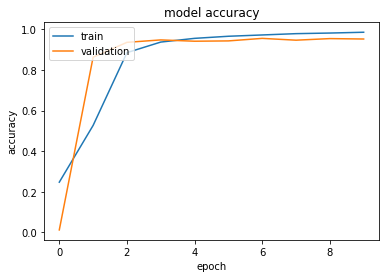

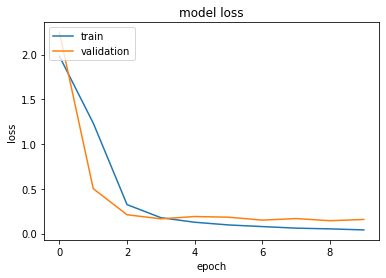

In [20]:
# accuracy plot
fig1 = plt.figure()
plt.plot(epoch_train_acc)
plt.plot(epoch_validation_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig1.savefig("multisize_accuracy.png")

# loss plot
fig2 = plt.figure()
plt.plot(epoch_train_loss)
plt.plot(epoch_validation_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig2.savefig("multisize_loss.png")

### 混同行列

In [21]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7 ,8], ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "None"])
    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7 ,8], ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "None"])
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

- validation confmat

Confusion matrix, without normalization
Normalized confusion matrix


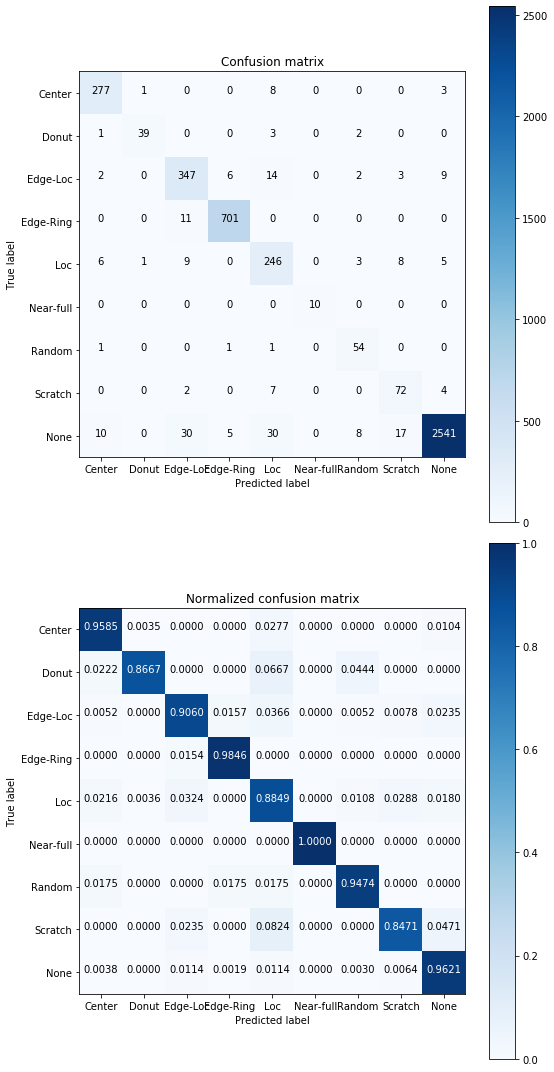

In [22]:
# Compute confusion matrix
y_validation_predict = np.argmax(model.predict(x_validation), axis=1)
y_validation_max = np.argmax(y_validation, axis=1)
cnf_matrix = confusion_matrix(y_validation_max, y_validation_predict)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(8, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()
fig.savefig("multisize_valiconfmat.png")

- test confmat

Confusion matrix, without normalization
Normalized confusion matrix


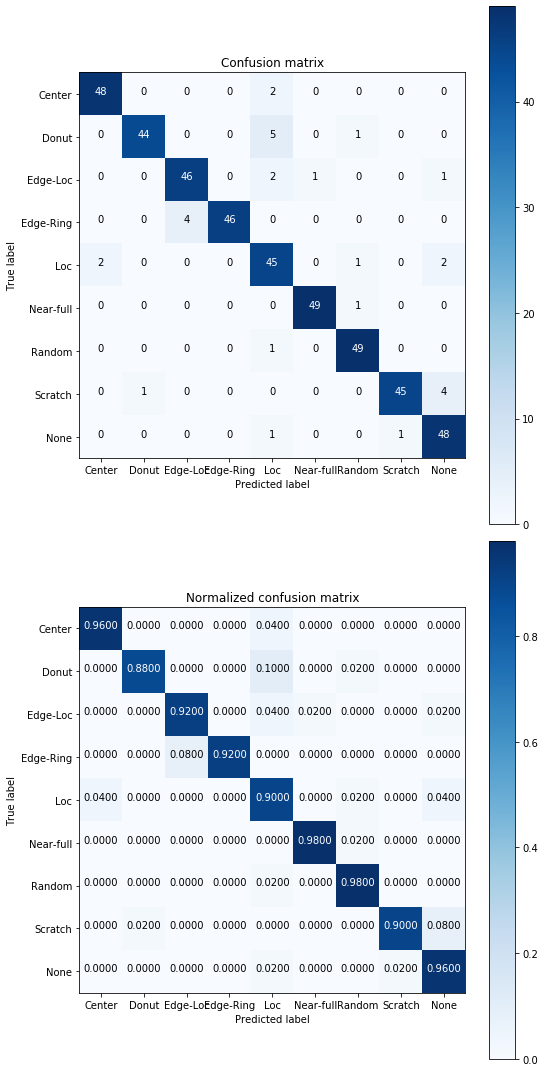

In [23]:
# Compute confusion matrix
y_test_predict = np.argmax(model.predict(x_test), axis=1)
y_test_max = np.argmax(y_test, axis=1)
cnf_matrix = confusion_matrix(y_test_max, y_test_predict)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(8, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()
fig.savefig("multisize_testconfmat.png")

In [24]:
import requests

# LINEの設定
path = './lineapi.txt'
with open(path) as f:
    s = f.read()
    line_token = s.rstrip('\n')

# LINEに通知する関数
def line_notify(text):
    url = "https://notify-api.line.me/api/notify"
    data = {"message": text}
    headers = {"Authorization": "Bearer " + line_token}
    proxies = {
        'http': 'http://proxy.uec.ac.jp:8080',
        'https': 'https://proxy.uec.ac.jp:8080',
    }
    requests.post(url, headers=headers)#, proxies=proxies)

# LINEに画像を送る関数
def line_notify_img(text, imgpath):
    url = "https://notify-api.line.me/api/notify"
    data = {"message": text, "notificationDisabled": True}
    files = {"imageFile": open(imgpath, "rb")}
    headers = {"Authorization": "Bearer " + line_token}
    proxies = {
        'http': 'http://proxy.uec.ac.jp:8080',
        'https': 'https://proxy.uec.ac.jp:8080',
    }
    requests.post(url, data=data, files=files, headers=headers)#, proxies=proxies)
    
line_notify("学習が終了しました ")
# line_notify("Shawon: " + str(shawon) + ", rotation_num: " + str(rotation_num) + ", inversion: " + str(inversion) + ", trials: " + str(trials))
line_notify_img("正解率", "multisize_accuracy.png")
line_notify_img("Loss", "multisize_loss.png")
line_notify_img("validation混同行列", "multisize_valiconfmat.png")
line_notify_img("test混同行列", "multisize_testconfmat.png")
line_notify("train:" + str(trainscore) + "\nvali:" + str(valiscore) + "\ntest:" + str(testscore))

SSLError: HTTPSConnectionPool(host='notify-api.line.me', port=443): Max retries exceeded with url: /api/notify (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1076)')))